### DỰ ĐOÁN THỜI GIAN GIAO HÀNG

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic
# CT geodesic trong thư viện Geopy sử dụng các tọa độ địa lý của 2 điểm
# (như Restaurant_latitude, Restaurant_longitude, Delivery_location_latitude, Delivery_location_longitude) 
# để tính toán khoảng cách giữa chúng trên bề mặt của Trái Đất. 
# Cho phép tính khoảng cách giữa các vị trí dựa trên tọa độ địa lý của chúng.

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [3]:
df_train = pd.read_csv('C:/Users/WELCOME/Desktop/Đồ án TTNT/Dataset/train.csv')
df_train.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [4]:
df_train.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

In [5]:
print("Train Dataset :", df_train.shape)

Train Dataset : (45593, 20)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

# Kiểm tra các số liệu thống kê có trong bảng với dữ liệu định tính 

In [7]:
#Kiểm tra giá trị thống kê cho các trường có kiểu dữ liệu số
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [8]:
#Kiểm tra giá trị thống kê cho các trường có kiểu dữ liệu số khác với kiểu dữ liệu số, freq: số lần xuất hiện
df_train.describe(exclude=np.number).T


,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


### Sau khi quan sát, ta đã rút ra được:

1. Có nhiều giá trị null ở trong cột "Time_Orderd".
2. Cần phải chỉnh lại loại DL cho cột "Weatherconditions" và "Time_taken(min)"
3. Cả hai dữ liệu định lượng (đo or đếm đc) và định tính ( 0 đo đc, chỉ để phân loại) đều có trong dataset.
4. ID & Delivery_person_ID là 2 cột không cần thiết trong việc xây dựng mô hình.

### Khám phá từng cột một

In [9]:
#Explore each column
for column in df_train.columns:
    print(column)
    print(df_train[column].value_counts()) #đếm slg gtri duy nhất trong mỗi cột
    print("------------------------------------")

ID
ID
0x4607     1
0x1f3e     1
0xe251     1
0x3f31     1
0x4a78     1
          ..
0xc3f1     1
0x5db7     1
0x1985     1
0xceda     1
0x5fb2     1
Name: count, Length: 45593, dtype: int64
------------------------------------
Delivery_person_ID
Delivery_person_ID
PUNERES01DEL01     67
JAPRES11DEL02      67
HYDRES04DEL02      66
JAPRES03DEL01      66
VADRES11DEL02      66
                   ..
DEHRES18DEL03       7
AURGRES11DEL03      7
KOLRES09DEL03       6
KOCRES16DEL03       6
BHPRES010DEL03      5
Name: count, Length: 1320, dtype: int64
------------------------------------
Delivery_person_Age
Delivery_person_Age
35      2262
36      2260
37      2227
30      2226
38      2219
24      2210
32      2202
22      2196
29      2191
33      2187
28      2179
25      2174
34      2166
26      2159
21      2153
27      2150
39      2144
20      2136
31      2120
23      2087
NaN     1854
50        53
15        38
Name: count, dtype: int64
------------------------------------
Delivery_perso

- ID: Có 45593 giá trị duy nhất trong cột ID.
- Delivery_person_ID: Có một số ID của shipper xuất hiện nhiều lần.
- Weatherconditions: Có một số điều kiện thời tiết xuất hiện nhiều lần như "Sunny" hoặc "Cloudy".
- Type_of_order: Loại đơn hàng "Snack" xuất hiện nhiều nhất.
- Type_of_vehicle: Xe máy là phương tiện phổ biến nhất
- Festival: Khách thường mua hàng vào dịp không phải ngày lễ
- City: Có nhiều đơn hàng được thực hiện ở các thành phố khác nhau.

# Data Cleaning

### Chỉnh sửa tên cột

In [10]:
def update_column_name(df):
    #Đổi tên cột Weatherconditions
    df.rename(columns={'Weatherconditions': 'Weather_conditions'},inplace=True)
    
update_column_name(df_train)
print(df_train.columns)

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')


### Biến đổi các giá trị trong cột thành những giá trị dễ đọc 

In [11]:

def extract_column_value(df):
    #Chỉnh sửa cột Time và chuyển dữ liệu thành loại int
    df['Time_taken(min)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    # chia thành 2 phần = khoảng trắng, sau đó chỉ lấy phần thứ 2 (số phút), rồi chuyển số phút -> int
    
    #Chỉnh sửa cột Weather conditions
    df['Weather_conditions'] = df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip())
    #Thêm mã thành phố từ Delivery person ID
    df['City_code']=df['Delivery_person_ID'].str.split("RES", expand=True)[0]
    
extract_column_value(df_train)
df_train[['Time_taken(min)','Weather_conditions','City_code']].head()

,Time_taken(min),Weather_conditions,City_code
0,24,Sunny,INDO
1,33,Stormy,BANG
2,26,Sandstorms,BANG
3,21,Sunny,COIMB
4,30,Cloudy,CHEN


### Xóa những cột không dùng trong việc xây dựng Model

In [12]:

def drop_columns(df):
    df.drop(['ID','Delivery_person_ID'],axis=1,inplace=True)
    
print("Before No. of columns: ",df_train.shape[1])
drop_columns(df_train)
print("After No. of columns: ",df_train.shape[1])

Before No. of columns:  21
After No. of columns:  19


### Kiểm tra các giá trị trùng lặp

In [13]:

if (len(df_train[df_train.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


### Chỉnh sửa kiểu dữ liệu phù hợp 

In [14]:

def update_datatype(df):
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")
    
update_datatype(df_train)

### Biến đổi string "NaN" thành np.nan
(np.nan là gtri đặc biệt để biểu thị gtri missing value)

In [15]:
def convert_nan(df):
    df.replace('NaN', float(np.nan), regex=True,inplace=True)

convert_nan(df_train)

### Kiểm tra các giá trị null

In [16]:

df_train.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weather_conditions              616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
City_code                         0
dtype: int64

In [17]:
#Handle null values
def handle_null_values(df):
    df['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True)
    df['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True)
    df['City'].fillna(df['City'].mode()[0], inplace=True) #mode: điền = gtri xuất hiện nhiều nhất
    df['Festival'].fillna(df['Festival'].mode()[0], inplace=True)
    df['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
    df['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
    df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)
    
handle_null_values(df_train)
df_train.isnull().sum()

Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions                0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
City_code                         0
dtype: int64

### Handling outliers 

In [18]:
upper_limit = df_train['Delivery_person_Age'].mean() + 3 * df_train['Delivery_person_Age'].std()
upper_limit

46.681466731509715

In [19]:
lower_limit = df_train['Delivery_person_Age'].mean() - 3*df_train['Delivery_person_Age'].std()
lower_limit

12.08136966881489

In [20]:
df_train = df_train[(df_train['Delivery_person_Age'] < upper_limit) & (df_train['Delivery_person_Age'] > lower_limit)]
df_train

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,32,JAP
45589,21.0,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,Windy,Jam,0,Buffet,motorcycle,1.0,No,Metropolitian,36,AGR
45590,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,16,CHEN
45591,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,26,COIMB


In [21]:
df_train = df_train[~(df_train["Restaurant_latitude"] == 0)]\
    .reset_index(drop=True).copy()
df_train

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41902,35.0,4.2,23.371292,85.327872,23.481292,85.437872,2022-03-08,21:45:00,21:55:00,Windy,Jam,2,Drinks,motorcycle,1.0,No,Metropolitian,33,RANCHI
41903,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,32,JAP
41904,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,16,CHEN
41905,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,26,COIMB


In [22]:
df_train = df_train[~(df_train["Delivery_location_latitude"] == 0)]\
    .reset_index(drop=True).copy()
df_train

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41902,35.0,4.2,23.371292,85.327872,23.481292,85.437872,2022-03-08,21:45:00,21:55:00,Windy,Jam,2,Drinks,motorcycle,1.0,No,Metropolitian,33,RANCHI
41903,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,32,JAP
41904,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,16,CHEN
41905,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,26,COIMB


In [23]:
df_train = df_train[~(df_train["Restaurant_latitude"] < 7.00)]\
    .reset_index(drop=True).copy()
df_train

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41493,35.0,4.2,23.371292,85.327872,23.481292,85.437872,2022-03-08,21:45:00,21:55:00,Windy,Jam,2,Drinks,motorcycle,1.0,No,Metropolitian,33,RANCHI
41494,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,32,JAP
41495,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,16,CHEN
41496,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,26,COIMB


### Kiểm tra xem một lần nữa dataset đã sạch chưa 

In [24]:
for column in df_train.columns:
    print(column)
    print(df_train[column].value_counts())
    print("------------------------------------")

Delivery_person_Age
Delivery_person_Age
25.0    3460
35.0    2093
36.0    2070
37.0    2042
30.0    2036
24.0    2035
22.0    2021
38.0    2018
33.0    2010
29.0    2007
32.0    1999
28.0    1997
34.0    1986
26.0    1980
39.0    1968
27.0    1966
21.0    1961
20.0    1955
31.0    1936
23.0    1933
15.0      25
Name: count, dtype: int64
------------------------------------
Delivery_person_Ratings
Delivery_person_Ratings
4.7    8009
4.8    6535
4.9    6455
4.6    6359
5.0    3649
4.5    3053
4.2    1329
4.1    1320
4.3    1299
4.4    1243
4.0     994
3.5     236
3.8     215
3.7     202
3.6     193
3.9     174
3.4      31
3.1      28
3.2      26
1.0      25
3.3      23
2.7      21
2.6      20
2.5      18
2.9      18
2.8      17
3.0       6
Name: count, dtype: int64
------------------------------------
Restaurant_latitude
Restaurant_latitude
26.911378    182
26.914142    180
26.902908    176
26.902940    176
26.892312    176
            ... 
25.453436     29
23.218998     29
9.988483     

In [25]:
obj=df_train.select_dtypes(include=['object'])
num=df_train.select_dtypes(include=['int64','float64'])
print(obj.columns) #DL dạng chuỗi
print(num.columns) #DL dạng số

Index(['Time_Orderd', 'Time_Order_picked', 'Weather_conditions',
       'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'Festival',
       'City', 'City_code'],
      dtype='object')
Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Vehicle_condition',
       'multiple_deliveries', 'Time_taken(min)'],
      dtype='object')


In [26]:
obj=['Weatherconditions', 'Road_traffic_density', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City']
num=['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition', 'distance']

df_train[num]

KeyError: "['distance'] not in index"

# Data Visualization

In [ ]:
df_train['Delivery_person_Age'] = df_train['Delivery_person_Age'].astype('float')

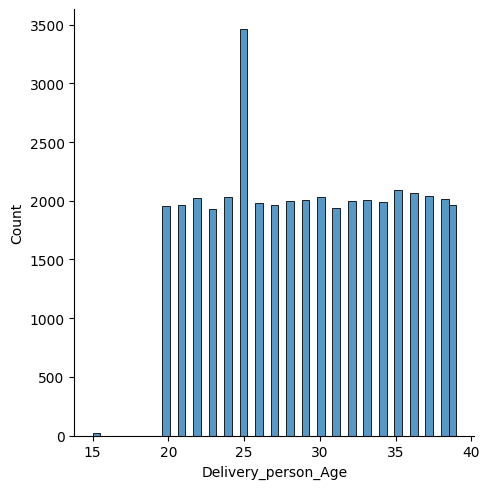

In [27]:
sns.displot(df_train['Delivery_person_Age'])
#biểu đồ phân phối

### Delivery_person_Ratings

In [28]:
df_train['Delivery_person_Ratings']=df_train['Delivery_person_Ratings'].astype('float64')

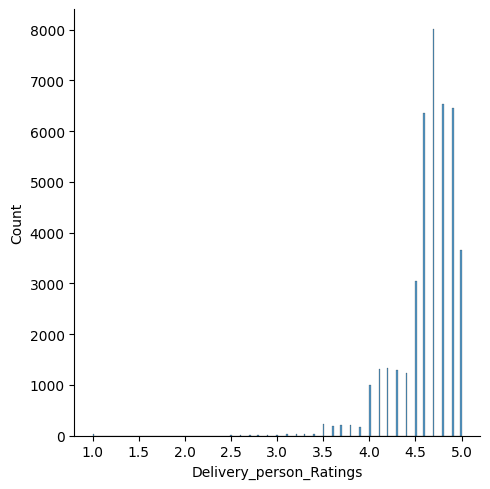

In [29]:
sns.displot(df_train['Delivery_person_Ratings'])

### Type_of_Order

<Axes: xlabel='Type_of_order', ylabel='count'>

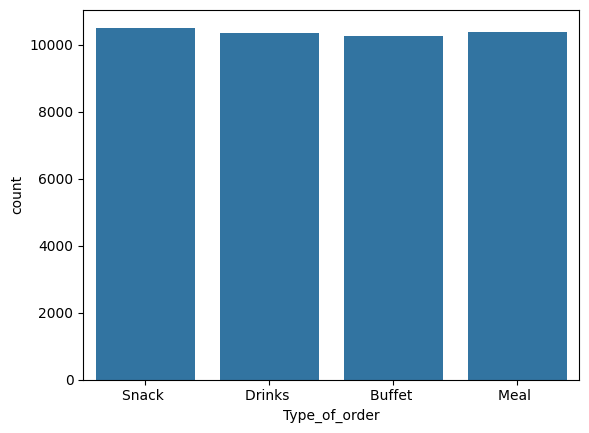

In [30]:
plt.figure(dpi=100)
sns.countplot(data=df_train,x='Type_of_order')


<Axes: xlabel='Type_of_vehicle', ylabel='count'>

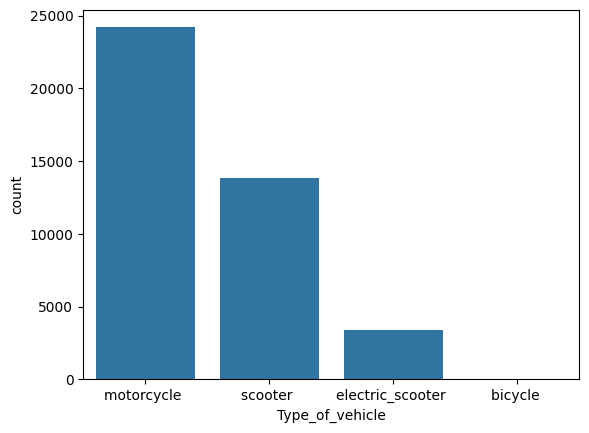

In [31]:
plt.figure(dpi=100)
sns.countplot(data=df_train,x='Type_of_vehicle')

<Axes: xlabel='City', ylabel='count'>

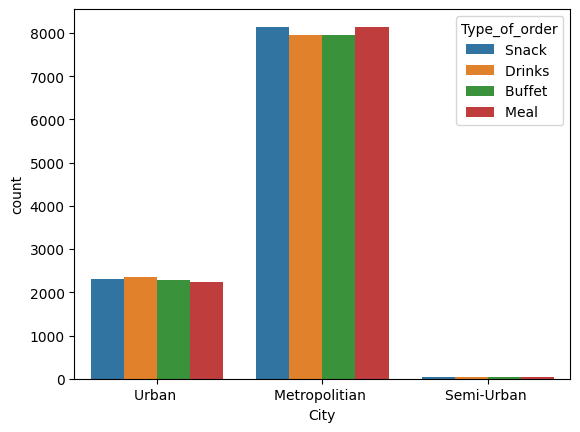

In [32]:
sns.countplot(x=df_train.City,hue=df_train.Type_of_order)
#đô thị, tp đô thị, ngoại ô

<Axes: xlabel='City', ylabel='count'>

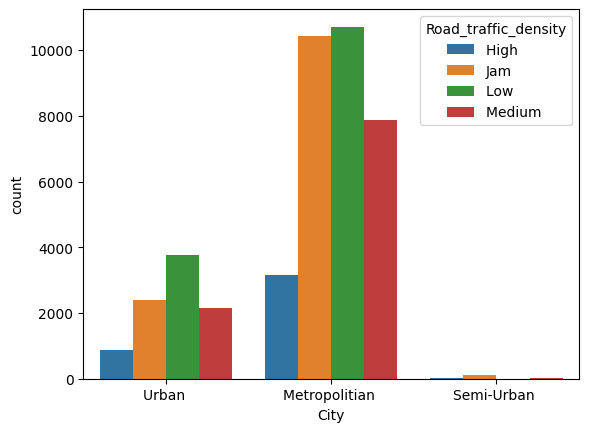

In [33]:
sns.countplot(x=df_train.City,hue=df_train.Road_traffic_density)
#sự tắc nghẽn giao thông


<Axes: xlabel='Type_of_order', ylabel='count'>

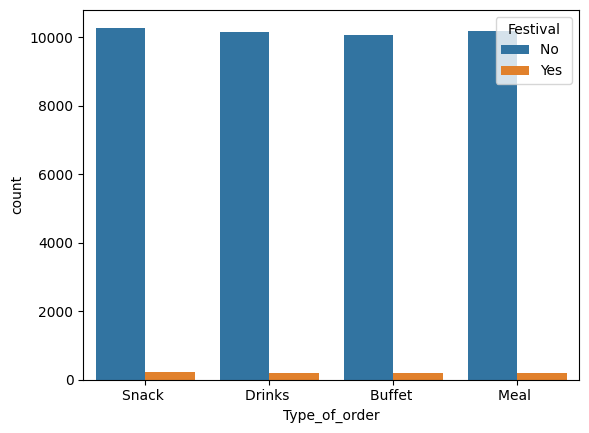

In [34]:
sns.countplot(x=df_train.Type_of_order,hue=df_train.Festival) #Festival doesn't affect the food ordering frequency

<Axes: xlabel='Vehicle_condition', ylabel='count'>

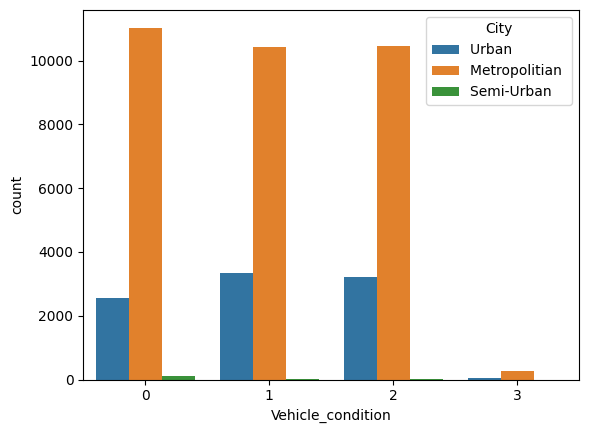

In [35]:
sns.countplot(x=df_train.Vehicle_condition,hue=df_train.City) #Vehicle condition is overall good in all 3 cities
#It has taken more time to deliver food in semi-urban cities, likely due to traffic or road conditions.

<Axes: xlabel='Time_taken(min)', ylabel='Density'>

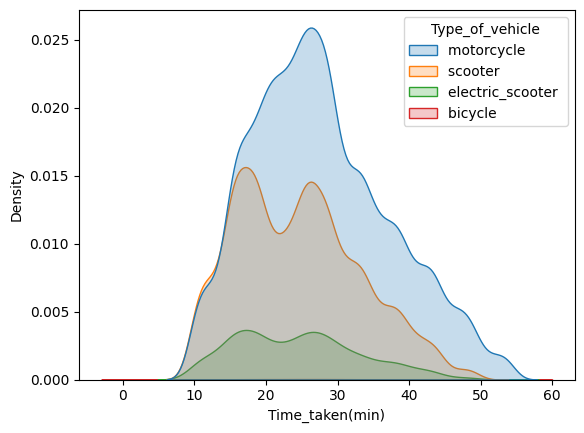

In [36]:
plt.figure(dpi=100)
sns.kdeplot(data=df_train,x='Time_taken(min)', hue='Type_of_vehicle', fill=True)
# most of the delivery is done through motorcylce and also have much higher mean delivery time compared to others

### Heatmap

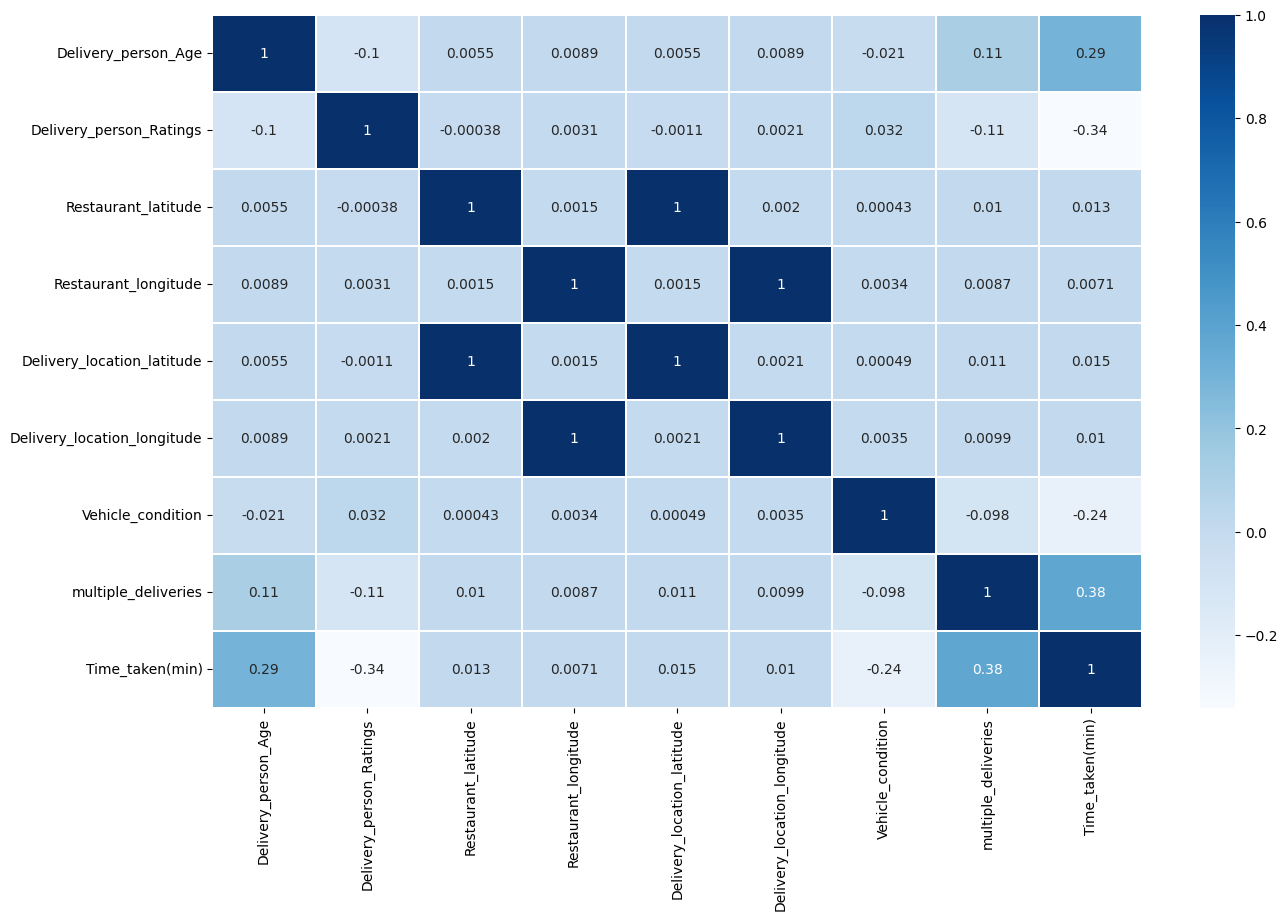

In [37]:
# plt.figure(figsize=(12,12))
# sns.heatmap(df_train.corr(),annot=True,linewidths=0.6,fmt=".2f",cmap="coolwarm")

# Correlation HeatMap
plt.figure(figsize=(15,9))
sns.heatmap(df_train.select_dtypes(include=['float64', 'int64']).corr(), annot=True, linewidth=0.1, cmap="Blues")

plt.show()


# Feature Engineering

In [38]:
def extract_date_features(data):
    data["day"] = data.Order_Date.dt.day
    data["month"] = data.Order_Date.dt.month
    data["quarter"] = data.Order_Date.dt.quarter
    data["year"] = data.Order_Date.dt.year
    data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
    data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
    data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
    data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
    data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
    data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
    #Ngày thứ 5 và thứ 6 trong tuần là thứ sáu và thứ bảy
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)

extract_date_features(df_train)
df_train.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO,19,3,1,2022,5,0,0,0,0,0,0,1
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG,25,3,1,2022,4,0,0,0,0,0,0,0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG,19,3,1,2022,5,0,0,0,0,0,0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB,5,4,2,2022,1,0,0,0,0,0,0,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN,26,3,1,2022,5,0,0,0,0,0,0,1


In [39]:
# #Tính khoảng cách thời gian
# def calculate_time_diff(df):
#     # Tính khoảng cách thời gian từ khi đặt hàng đến khi shipper lấy đơn hàng 
#     df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
#     df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])
    
#     df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(df['Time_Order_picked'] < df['Time_Orderd'], pd.DateOffset(days=1), pd.DateOffset(days=0)) + df['Time_Order_picked']
#     df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
    
#     df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60
    
#     # Xử lý các giá trị null bằng cách điền vào giá trị trung vị
#     df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)
    
#     # Bỏ tất cả các cột liên quan đến ngày và giờ
#     df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)


# calculate_time_diff(df_train)
# df_train.head()





def calculate_time_diff(df):
    # Chuyển đổi các cột thời gian thành định dạng datetime
    df['Order_Date'] = pd.to_datetime(df['Order_Date'])
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])
    
    # Tính toán thời gian đặt hàng và thời gian lấy hàng
    df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(df['Time_Order_picked'] < df['Time_Orderd'], pd.DateOffset(days=1), pd.DateOffset(days=0)) + df['Time_Order_picked']
    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
    
    # Chuyển đổi các cột thành kiểu datetime nếu chúng không phải là kiểu datetime
    df['Time_Order_picked_formatted'] = pd.to_datetime(df['Time_Order_picked_formatted'])
    df['Time_Ordered_formatted'] = pd.to_datetime(df['Time_Ordered_formatted'])
    
    # Tính toán thời gian chuẩn bị đơn hàng
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60
    
    # Xử lý giá trị null bằng cách điền vào giá trị trung vị
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)
    
    # Bỏ tất cả các cột liên quan đến ngày và giờ
    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)

calculate_time_diff(df_train)
df_train.head()







,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO,19,3,1,2022,5,0,0,0,0,0,0,1,15.0
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG,25,3,1,2022,4,0,0,0,0,0,0,0,5.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG,19,3,1,2022,5,0,0,0,0,0,0,1,15.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB,5,4,2,2022,1,0,0,0,0,0,0,0,10.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN,26,3,1,2022,5,0,0,0,0,0,0,1,15.0


In [40]:
#Tính toán khoảng cách giữa địa điểm nhà hàng và địa điểm giao hàng
def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']= df['distance'].astype("str").str.extract('(\d+)').astype("int64")
    
calculate_distance(df_train)
df_train.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG,25,3,1,2022,4,0,0,0,0,0,0,0,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB,5,4,2,2022,1,0,0,0,0,0,0,0,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,6


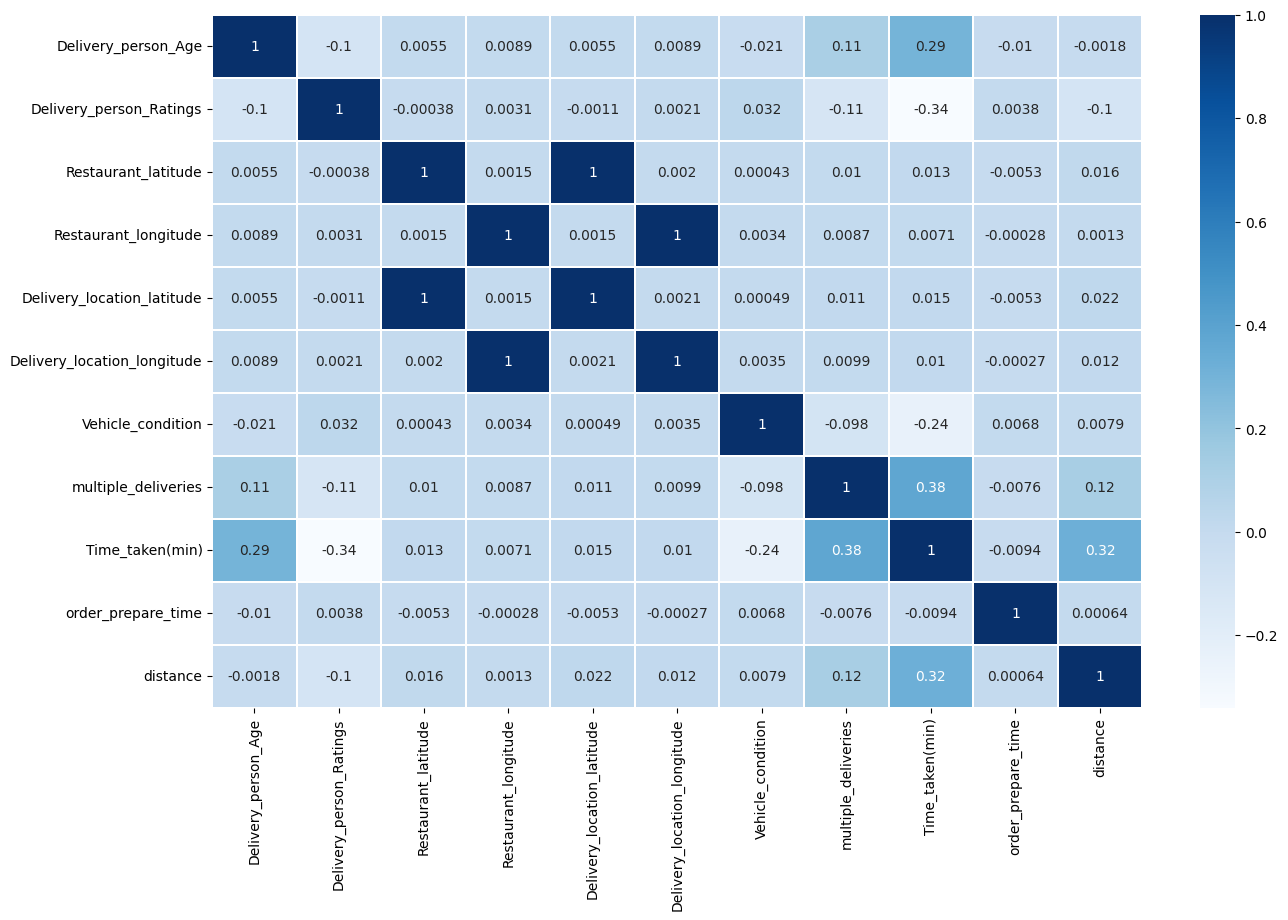

In [41]:
#nháp thử

# Correlation HeatMap
plt.figure(figsize=(15,9))
sns.heatmap(df_train.select_dtypes(include=['float64', 'int64']).corr(), annot=True, linewidth=0.1, cmap="Blues")

plt.show()


# Data Preprocessing

## Label Encoding

In [42]:
def label_encoding(df):
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

label_encoding(df_train)
df_train.head(10)


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,4,0,2,3,2,0.0,0,2,24,10,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,3,1,2,3,3,1.0,0,0,33,3,25,3,1,2022,4,0,0,0,0,0,0,0,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2,2,0,1,2,1.0,0,2,26,3,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,4,3,0,0,2,1.0,0,0,21,6,5,4,2,2022,1,0,0,0,0,0,0,0,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,0,0,1,3,3,1.0,0,0,30,5,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,6
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,0,1,0,0,2,1.0,0,2,26,9,11,3,1,2022,4,0,0,0,0,0,0,0,10.0,4
6,33.0,4.7,23.369746,85.339820,23.479746,85.449820,1,1,1,2,3,1.0,0,0,40,19,4,3,1,2022,4,0,0,0,0,0,0,0,15.0,16
7,35.0,4.6,12.352058,76.606650,12.482058,76.736650,0,3,2,2,2,1.0,0,0,32,17,14,3,1,2022,0,0,0,0,0,0,0,0,5.0,20
8,22.0,4.8,17.433809,78.386744,17.563809,78.516744,3,1,0,0,2,1.0,0,0,34,9,20,3,1,2022,6,0,0,0,0,0,0,1,10.0,19
9,36.0,4.2,30.327968,78.046106,30.397968,78.116106,1,1,2,3,2,3.0,0,0,46,7,12,2,1,2022,5,0,0,0,0,0,0,1,15.0,10


## Train test split

In [43]:
# train = df_train.loc[df_train.index < 33198]
# test = df_train.loc[df_train.index >= 33198]

#Split features & label
X = df_train.drop('Time_taken(min)', axis=1)  # Features
y = df_train['Time_taken(min)']  # dự đoán

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33198, 29)
(33198,)
(8300, 29)
(8300,)


## Standardization

In [44]:
# Tạo một đối tượng có bộ chia tỷ lệ tiêu chuẩn
scaler = StandardScaler()

# Phù hợp với bộ chia tỷ lệ trên dữ liệu đào tạo
scaler.fit(X_train)

# Chuẩn hóa bộ dữ liệu train
X_train = scaler.transform(X_train)

# Chuẩn hóa trên bộ dữ liệu test
X_test = scaler.transform(X_test)



# Model Building

### Các bước thực hiện
**1. Sử dụng xác thực chéo và điều chỉnh siêu tham số để xác định mô hình hồi quy tối ưu.**

**2. Xây dựng mô hình dự đoán bằng cách sử dụng mô hình tốt nhất đã được xác định.**

**3. Đánh giá hiệu suất của mô hình trên dữ liệu thử nghiệm để đánh giá độ chính xác và độ tin cậy của nó.**

### Cross Validation

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Tìm mô hình tốt nhất
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(),
]

param_grid = [
    {},  
    {'max_depth': [3, 5, 7]},
    {'n_estimators': [100, 200, 300]},
    {'n_estimators': [20, 25, 30], 'max_depth': [5, 7, 9]},
]

for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    print(f"{model.__class__.__name__}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best R2 score:", grid_search.best_score_)
    print()


LinearRegression:
Best parameters: {}
Best R2 score: 0.4884665959302293

DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best R2 score: 0.7201357637875068



# Future Prediction

### Model Building

In [ ]:
# Create a XGB regressor model
model = xgb.XGBRegressor(n_estimators=20,max_depth=9)

# Fit the model on the training data
model.fit(X_train, y_train,
         eval_set = [(X_train, y_train), (X_test, y_test)], verbose = True)

**rmse giá trị càng thấp thì độ chính xác của mô hình càng cao**

### Model Evaluation

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))
print("Mean Squared Error (MSE):", round(mse,2))
print("Root Mean Squared Error (RMSE):", round(rmse,2))
print("R-squared (R2) Score:", round(r2,2))

In [ ]:
df_train.columns

In [ ]:
test['prediction_time'] = model.predict(X_test)
def drop_columns(df):
    df.drop(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Weather_conditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'City_code', 'day', 'month', 'quarter', 'year',
       'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'is_year_start', 'is_year_end', 'is_weekend',
       'order_prepare_time', 'distance'],axis=1,inplace=True)
drop_columns(test)

In [ ]:
test.tail(100)

In [ ]:
test.head(100)

# Conclusion

**In conclusion, the food delivery prediction model was developed using XGBoost, achieving an impressive R2 score of 0.82. Moving forward, potential enhancements include identifying the best features, conducting additional feature engineering, and exploring other optimization techniques to further improve the model's performance and accuracy. These steps will contribute to fine-tuning the model and unlocking its full potential in predicting food delivery timings accurately.**


Trong kết luận, mô hình dự đoán giao hàng đồ ăn đã được phát triển bằng cách sử dụng XGBoost, đạt được điểm R2 ấn tượng là 0.82. Đối với các bước tiếp theo, các cải tiến tiềm năng bao gồm xác định các đặc trưng tốt nhất, tiến hành thêm công việc tạo đặc trưng, và khám phá các kỹ thuật tối ưu hóa khác để cải thiện hiệu suất và độ chính xác của mô hình. Những bước này sẽ đóng góp vào việc điều chỉnh mô hình và mở khóa toàn bộ tiềm năng của nó trong việc dự đoán thời gian giao hàng đồ ăn một cách chính xác.